# SelectFeatures
This notebook shows the development of how we shrink the size of features from `SeekFeatures` to study with. We used the following method to analyze the weight of each feature:

* RIDGE (Ridge Regression)
* LASSO (Least Absolute Shrinkage and Selection Operator)
* Random Forest
* RFECV (Recursive Feature Elimination with Cross-validation)

We use MSE to compare and evaluate these methods for final decision making.<br>

#### Use ``ChemFeatures`` to generate a dataframe of features.

In [1]:
import pandas as pd
# Module for extracting ChemInfo
from SeekFeatures import *
import mordred
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# plotting package
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'SeekFeatures'

In [2]:
# Use 100K data for demonstration
data = pd.read_csv('../Database/HCEPD_100K.csv') 
# randomly choose 50 data to illustrate the analysis
data50 = data.sample(frac=0.0005, replace=True, random_state=1)
data50.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
98539,1088440,C1C=c2c3C=CCc3c3c(c4[SiH2]C(=Cc4c4=C[SiH2]C=c3...,C24H18OSi2,378.5772,2.210120,0.101278,335.853285,-4.701278,0.935055,-3.766222,C1=Cc2c(C1)c1c(c3[SiH2]C(=Cc3c3=C[SiH2]C=c13)c...
77708,981491,[SiH2]1C=CC=C1c1cc2oc3c(c2cn1)c1ccccc1c1ccc2co...,C25H15NO2Si,389.4845,3.963986,0.827973,73.682314,-5.427973,2.160920,-3.267053,C1=CC=C([SiH2]1)c1cc2oc3c(c2cn1)c1ccccc1c1ccc2...
5192,476266,C1C=c2ccc3oc4c5CC(=Cc5c5cocc5c4c3c2=C1)C1=CC=CC1,C25H16O2,348.3994,0.191108,0.016986,173.158938,-4.616986,1.568570,-3.048416,C1=CC=C(C1)C1=Cc2c(C1)c1oc3ccc4=CCC=c4c3c1c1co...
98047,2265804,C1C=c2cccc(-c3cnc4c(c3)c3=CCC=c3c3c5CC=Cc5c5c[...,C30H20N2,408.5020,1.228499,0.125749,150.355508,-4.725749,1.678084,-3.047664,C1=Cc2c(C1)c1c(c3c[nH]cc23)c2ncc(cc2c2=CCC=c12...
50057,743772,[SiH2]1C=CC=C1c1cc2[se]c3c(c4nsnc4c4ccc5ccccc5...,C22H12N2OSSeSi,459.4618,6.193478,0.755948,126.092846,-5.355948,1.810543,-3.545405,C1=CC=C([SiH2]1)c1cc2[se]c3c(c4nsnc4c4ccc5cccc...


Generate a dataframe of chemical features by `seek_feature_with_replacement` where all missing values are replaced.

In [3]:
features_df = seek_feature_with_replacement(data50['SMILES_str'])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.24it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.26it/s]


In [4]:
features_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,22.849242,18.748733,0,0,37.470719,2.653959,5.203307,37.470719,1.387804,4.315068,...,10.667722,81.932870,378.089618,8.401992,1541,50,168.0,216.0,5.083333,5.583333
1,24.303896,17.849984,0,0,40.566571,2.630068,5.173358,40.566571,1.398847,4.371976,...,10.694011,82.753248,389.087205,8.842891,1981,55,176.0,223.0,5.583333,6.055556
2,22.889683,18.231741,0,0,37.375565,2.646058,5.103081,37.375565,1.384280,4.315003,...,10.631929,82.039662,348.115030,8.095698,1606,49,168.0,215.0,5.083333,5.555556
3,27.011003,20.666641,0,0,44.791001,2.644873,5.227188,44.791001,1.399719,4.478501,...,10.854354,87.133074,408.162649,7.849282,2574,63,198.0,254.0,6.055556,6.638889
4,23.596789,17.683212,0,0,38.963078,2.642836,5.177308,38.963078,1.391538,4.343921,...,10.669165,82.540321,459.960482,11.499012,1813,52,172.0,219.0,5.333333,5.805556


<br>

### Prepare Data for Regression
Use `Processing` to standardize the features data, and applies KFold cross-validation to split the data.
> `Processing.Scale_sample` is a standard scaler to the data.<br>
> `Processing.KFold_sampling` uses KFold CV method to split the data into train set and test set.<br>
> `Processing.SampleProcessor` contains both funcionalities above and generates automatically train set and test set for users.


In [5]:
from Processing import *

In [6]:
# the first argument is input of orginal dataframe, the second one
# is  the generated features dataframe.
X, y = Scale_sample(data50, features_df)

In [7]:
X_train, X_test, y_train, y_test = KFold_sampling(X, y, n = 10)

In [8]:
# SampleProcessor contains functionality of both standardscaler and KFold splitting.
X_train, X_test, y_train, y_test = SampleProcessor(data, features_df, n = 10)

In [9]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

45 5 45 5


### Linear regression model
Here, we chose two most commonly used linear regression models to shrink the coefficients: Ridge and LASSO. Both of them describes the weights of each feature contributing to the response in a linear model, and introduce a penalty term (&lambda;) to include the error from the magnitude of feature coefficient. The difference between them is the way they calculate the penalty. While RIDGE tries to shrink all coefficients closer to zero due to its square term, LASSO takes the absolutie value of coef to eliminate some 0 term and leave the significant term.<br>

We applied both methods to our dataset and tried to compare them by plotting error vs r2. They are included in ``ShrinkCoef``. Users can also decide which one to use for their data by calling these functions. 

* **Ridge regression (RR)**

In [10]:
from RR_model import *

In [11]:
# a and b are optional if only one set of data is given.
coefs_RR, lambdas_RR, error1_RR, error2_RR, modelRR = RRregress(X_train, y_train, a = X_test, b = y_test)

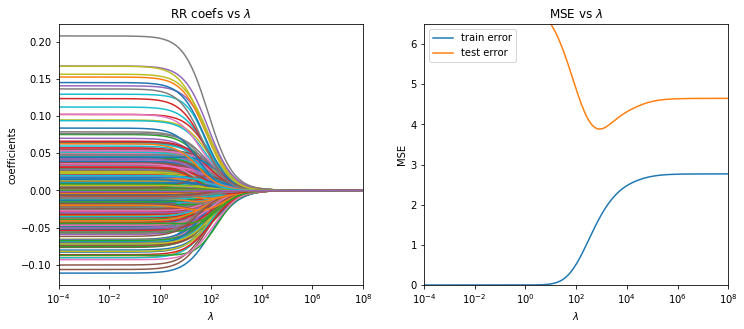

In [12]:
RR_plot(X_train, y_train, a = X_test, b = y_test)

In [13]:
# choose lambda = 1e-2 and find coef.
lam = list(lambdas_RR)[34]
coefs_RR[34]

array([-1.18309065e-03, -3.05696717e-03,  0.00000000e+00, ...,
       -7.15231140e-05, -2.31885111e-03, -1.66376607e-03])

In [14]:
# complie all coef at lambda = 1e-2 into a dataframe 
RR_df = pd.DataFrame({'Feature':features_df.columns.values, 'coefs_RR':coefs_RR[34]}).sort_values('coefs_RR',ascending=False)
RR_df.head()

,Feature,coefs_RR
1747,n9FARing,0.207730
1784,JGI6,0.167315
1788,JGI10,0.167035
1778,GGI10,0.156249
241,ATSC8c,0.152470


* **LASSO regression**

In [22]:
from LASSO_model import *

In [23]:
# a and b are optional if only one set of data is given.
coefs_LASSO, lambdas_LASSO, error1_LASSO, error2_LASSO, modelLASSO = \
  LASSOregress(X_train, y_train, a = X_test, b = y_test)\

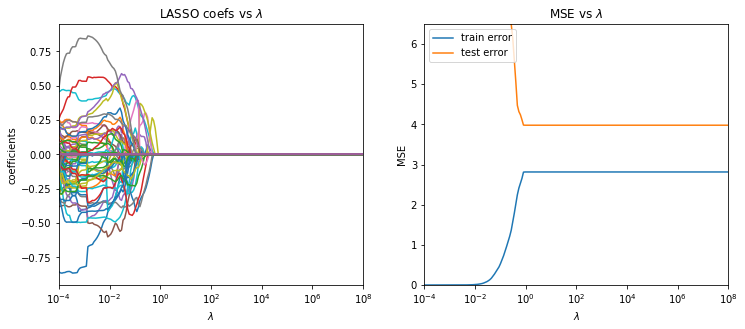

In [24]:
LASSO_plot(X_train, y_train, a = X_test, b = y_test)

LASSO has difficulty in converging the coefficients and returns an odd plot. The random error mainly comes from its strategy that taking absolute value of coefficients.

### Tree Based Methods
In addition to linear and non-linear regression, tree based model provides a more flexible method to describe the bonding between features and our target. 

* **Random Forest**

In [10]:
from RF_model import *


In [11]:
modelRF, RF_fit =  RFregress(X, y)

# We can get coefs of each feature from RFrank
RFrank = modelRF.feature_importances_

In [12]:
RF_df = pd.DataFrame({'Feature':features_df.columns.values, 'Rank':RFrank}).sort_values('Rank',ascending=False)
RF_df.head()

,Feature,Rank
441,AATSC1i,0.319183
537,MATS1i,0.181506
1039,SaaN,0.057964
514,MATS2pe,0.042666
232,AATS8i,0.023857


RF error for train set 0.5479967420096115
RF error for test set 1.9205746990101022


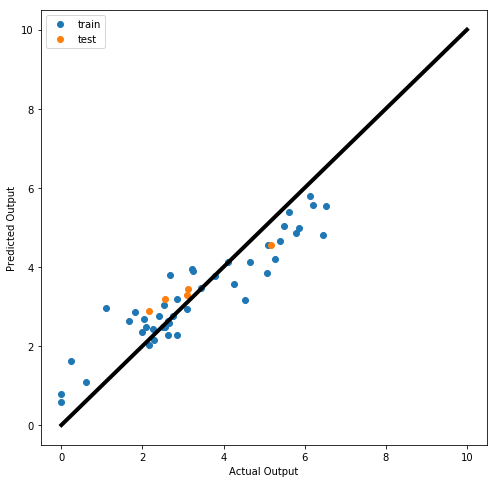

In [13]:
RF_plot(X_train, y_train, a = X_test, b = y_test,
        name1 = 'train', name2 = 'test')

### Recursive Feature Elimination (RFE)

Lastly, we also take advantage from a built-in function from sklearn ``RFE``, which returns a ranking of features that help user to choose from. It repeatedly performs learning process based on specified estimator (such as 'linear') and in each iteration, eliminates the least significant features based on coef_ and score (by specified scoring method). The repeating process runs through the entire input data until all the features have been analyzed. ``RFECV`` applies cross-validation strategy to iteration sampling and returns a cross-validated ranking of features.

Optimal number of features : 105
[False False False ... False False False]


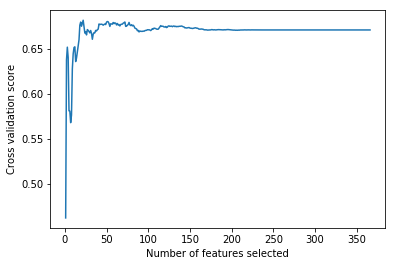

In [16]:
from RFECV_model import *
modelRFECV = RFECVregress(X, y, step = 5, estimator = 'linear', scoring_method='explained_variance' )

In [55]:
import seaborn as sns

In [46]:
modelRFECV.estimator_.coef_

array([[ 0.07103089,  0.05184214,  0.05393253,  0.0603927 ,  0.06988902,
         0.07320828,  0.05104625,  0.08693314,  0.06788118,  0.10193603,
         0.08521852,  0.0777612 ,  0.06364248,  0.07000474, -0.0623243 ,
        -0.06276281, -0.08953529, -0.0684357 ,  0.08520657, -0.09920219,
         0.06084556,  0.06094172,  0.05014915, -0.09252715, -0.08247747,
         0.09163816, -0.12664762,  0.08862513, -0.06647674,  0.10123263,
        -0.06010871, -0.05253964,  0.0781795 , -0.08404589, -0.07058038,
        -0.0559243 ,  0.06491136,  0.07748425,  0.08463304, -0.12266666,
        -0.10018568, -0.06319171, -0.06720373,  0.07637957,  0.06660468,
        -0.05766284, -0.06825954,  0.08274023,  0.09073755,  0.09703346,
         0.05609834,  0.04589613, -0.10106125, -0.09808851, -0.1180134 ,
        -0.06069107, -0.04847246, -0.05954322, -0.10356566,  0.08896882,
         0.08834016,  0.10310427, -0.07575967, -0.10799285,  0.08539449,
         0.10265367,  0.06736566, -0.06172991, -0.0

In [24]:
# obtain coefficients of each feature
RFECVrank = modelRFECV.ranking_
features60 = pd.DataFrame({'Feature':features_df.columns.values, 'Rank':RFECVrank}).sort_values('Rank')

# Compile into a dataframe
RFECV_df = pd.DataFrame()
RFECV_df['coef'] = np.array([modelRFECV.estimator_.coef_])
RFECV_df['Feature'] = features60.Feature[0:60]

Exception: Data must be 1-dimensional

In [23]:
RFECV_df.head()

,coef,Feature
0,"[[0.07103088644594437, 0.05184213828702289, 0....",NaN


In [67]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame({'Feature':RFECV_df2.Feature, 'Coef':RFECV_df2.coef})

# Sort the dataframe
meanplot = meanplot.sort_values('Coef', ascending=False)

In [70]:
meanplot.head

<bound method NDFrame.head of           Feature      Coef
1718   nG12FHRing  0.166993
497        MATS1v  0.162306
1035        SaaNH  0.141665
1783         JGI5  0.131861
271        ATSC2Z  0.129996
603       GATS3se  0.127148
537        MATS1i  0.125998
1323         SIC5  0.125130
234        ATSC1c  0.120683
444       AATSC4i  0.115186
237        ATSC4c  0.109157
441       AATSC1i  0.108934
1524    PEOE_VSA9  0.105516
1516    PEOE_VSA1  0.105514
572        GATS4s  0.097131
838        Xch-7d  0.095419
1741      nFARing  0.091411
259        ATSC8d  0.089304
359       AATSC0d  0.088434
1517    PEOE_VSA2  0.088351
1050      SssSiH2  0.084227
1100      MAXdsCH  0.081752
187        AATS8v  0.081720
1584      MDEN-22  0.080304
1277  AETA_eta_BR  0.075623
368       AATSC0s  0.075306
223        AATS8p  0.072829
1329         BIC5  0.069506
297       ATSC1se  0.066460
571        GATS3s -0.075429
241        ATSC8c -0.077336
960          NaaN -0.082715
633        GATS1i -0.086381
121         ATS5p 

In [96]:
sns.set(font_scale=2)
sns.set_style( 'whitegrid') 
coef_plot = sns.factorplot(y = 'Coef' , x = 'Feature', data = meanplot, kind = "bar", 
               size = 14, aspect = 1.9, orient = "v" , palette = 'ColdWarm')
coef_plot.set_xticklabels(rotation = 90, size = 20)
coef_plot.set_yticklabels(size = 20)
 


ValueError: ColdWarm is not a valid palette name

As suggested by RFECV result, we can select the 60 features with highest scores.

### Model Selection